In [1]:
# %load ../imports.py
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.datasets as datasets


In [2]:
DATASET_PATH = '../../dataset/private/diabetes.csv'
TARGET = 'Outcome'

In [3]:
data = pd.read_csv(
    DATASET_PATH,
)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print(
    data['Outcome'].value_counts(normalize=True)
)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [5]:
from sklearn.preprocessing import StandardScaler

X = data.drop([TARGET], axis=1)
y = data[TARGET]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

Accuracy: 0.75
Recall: 0.67
Precision: 0.65
F1 score: 0.66


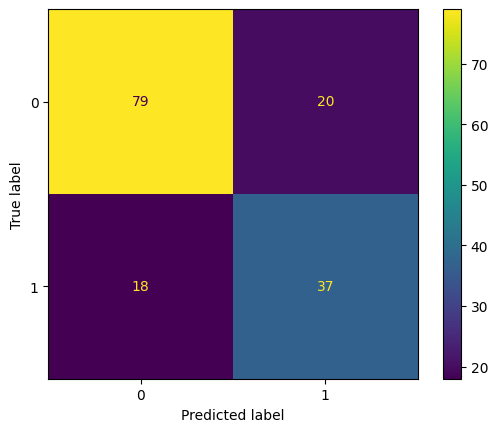

In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, ConfusionMatrixDisplay

def score_model(model, X, y):
    print(
        f"Accuracy: {accuracy_score(y, model.predict(X)):.2}",
        f"Recall: {recall_score(y, model.predict(X)):.2}",
        f"Precision: {precision_score(y, model.predict(X)):.2}",
        f"F1 score: {f1_score(y, model.predict(X)):.2}",
        sep='\n'
    )

    lr_confusion = ConfusionMatrixDisplay.from_estimator(
        model,
        X,
        y
    )
    plt.show()

score_model(lr, X_test, y_test)

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree_vanilla = DecisionTreeClassifier()
tree_vanilla.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy: 0.76
Recall: 0.73
Precision: 0.65
F1 score: 0.68


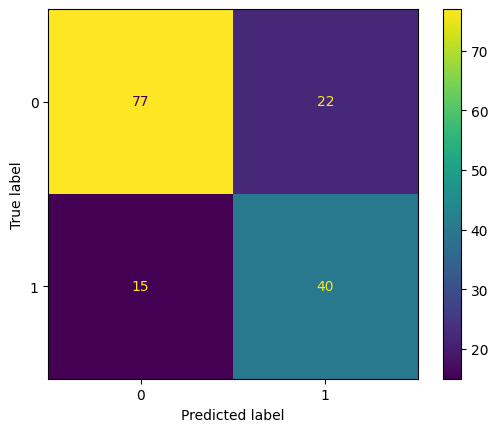

In [10]:
score_model(tree_vanilla, X_test, y_test)

Ошибки сбалансированы, а это значит что имеется развилка:
 - Если тест скрининговый, где важно поймать больных и рискованных, даже если не так точно, то recall важнее
 - Если цель получить точный исследовательский тест, минимизирующий ошибки как таковые и есть вера в достаточность данных, то нам важнее весь F1  

 Выберу F1

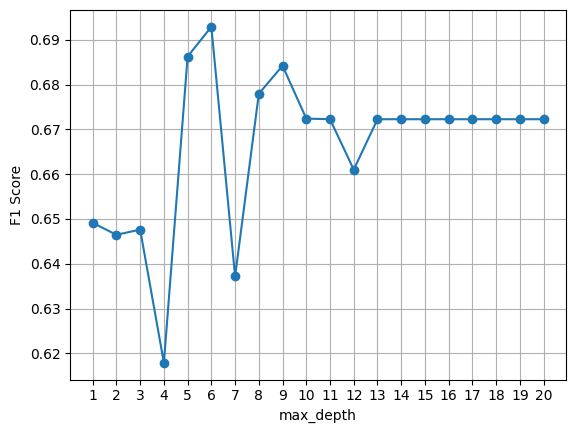

In [11]:
depths = list(range(1, 21))
f1_scores = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))

plt.plot(depths, f1_scores, marker='o')
plt.xticks(depths)
plt.xlabel("max_depth")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [12]:
best_depth = depths[f1_scores.index(max(f1_scores))]
print(best_depth)

6


Лучшая глубина дерева - 6

In [13]:
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

Accuracy: 0.75
Recall: 0.8
Precision: 0.61
F1 score: 0.69


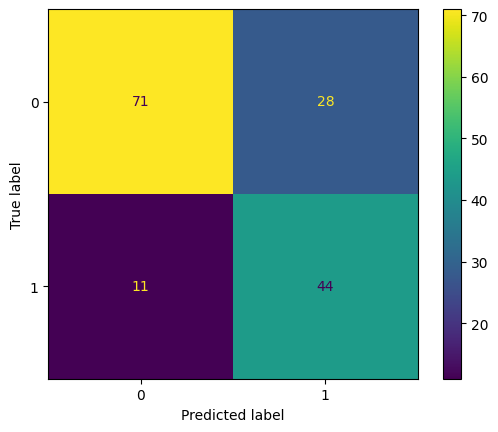

In [28]:
score_model(best_tree, X_test, y_test)

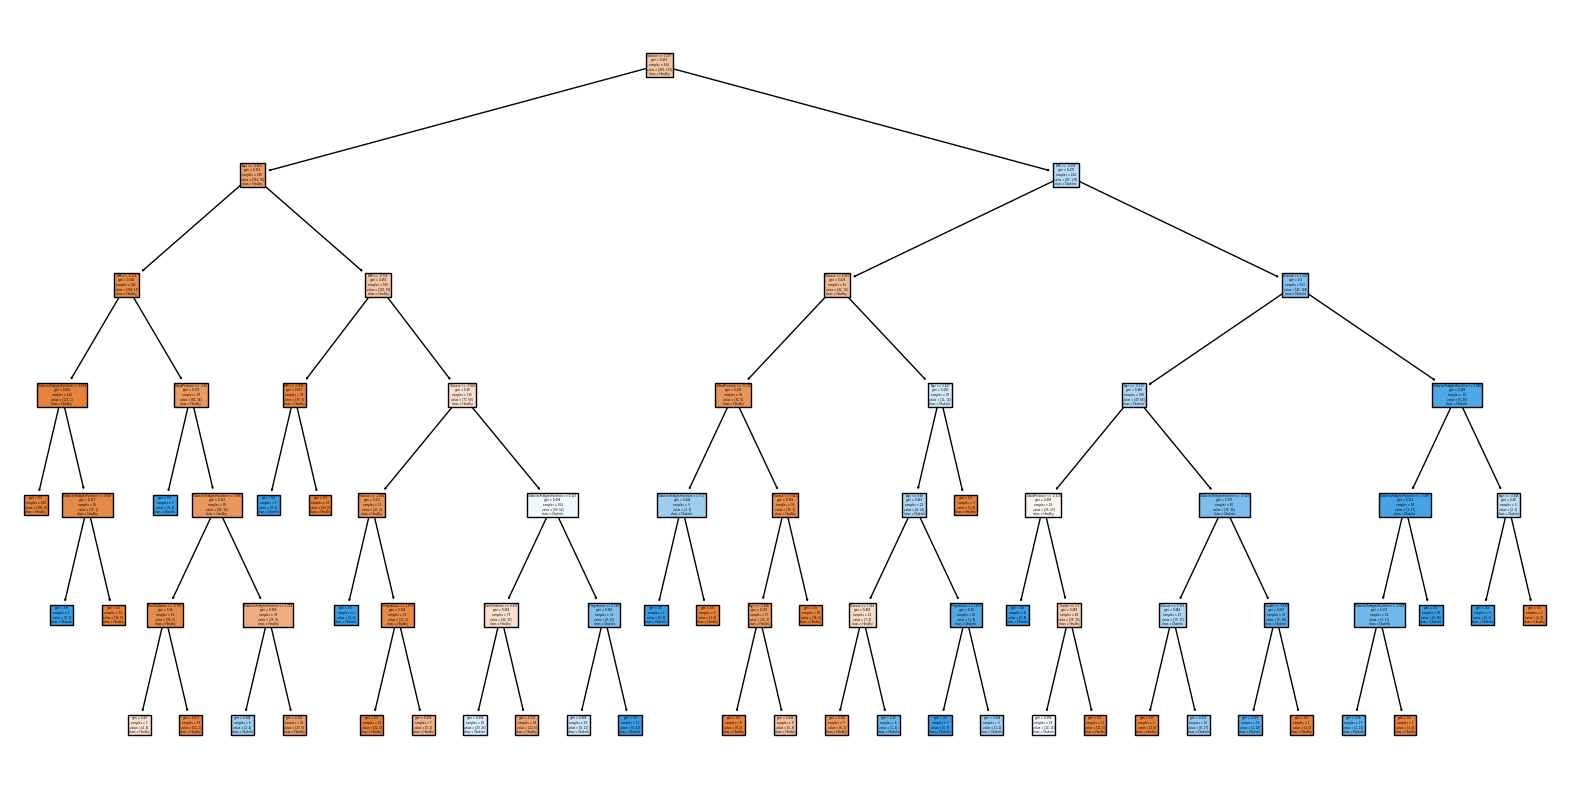

In [19]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20,10))
plot_tree(
    best_tree, 
    feature_names=data.drop(['Outcome'], axis=1).columns.to_list(), 
    class_names=["Healthy", "Diabetic"], 
    filled=True
)
plt.show()
fig.savefig('tree_image.png', dpi = 300)

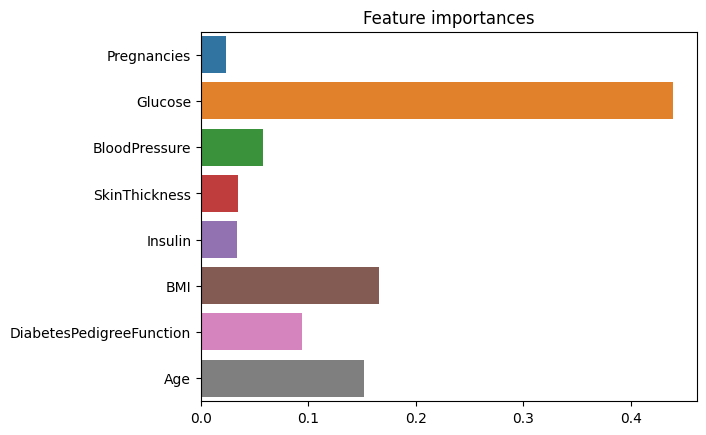

In [22]:
import seaborn as sns

importances = best_tree.feature_importances_
sns.barplot(x=importances, y=data.drop(['Outcome'], axis=1).columns.to_list())
plt.title("Feature importances")
plt.show()

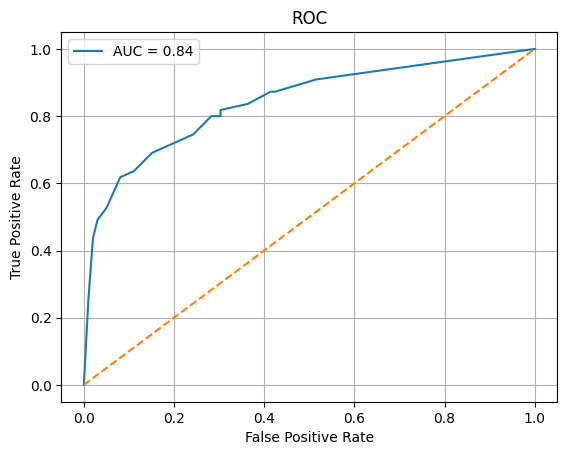

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

y_proba = best_tree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend()
plt.grid()
plt.show()

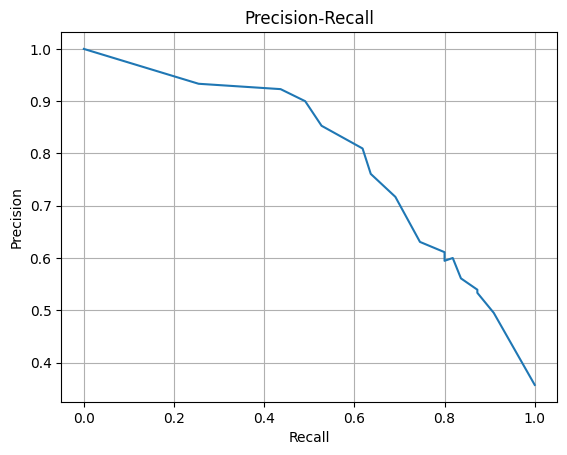

In [27]:
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.grid()
plt.show()